In [1]:
from miditoolkit.midi import parser as mid_parser  
from miditoolkit.midi import containers as ct
from numpy import array, linspace
from sklearn.neighbors import KernelDensity
from matplotlib.pyplot import plot
from scipy.signal import argrelextrema
from scipy.ndimage import gaussian_filter1d
import numpy as np
from miditoolkit.pianoroll import parser as pr_parser
from miditoolkit.pianoroll import utils
import matplotlib.pyplot as plt
import math

In [114]:
# helper functions
def read_midi(path,tpb=0):
    global DEFAULT_RESOLUTION
    mido_obj = mid_parser.MidiFile(path)
    tick_per_beat = mido_obj.ticks_per_beat
    if tpb==0:
        DEFAULT_RESOLUTION = tick_per_beat
    else:
        DEFAULT_RESOLUTION = tpb

    notes = [] 
    for instrument in mido_obj.instruments:
        for note in instrument.notes:
            #rescale tpb to 480
            note.start = int(note.start/tick_per_beat*DEFAULT_RESOLUTION)
            note.end=int(note.end/tick_per_beat*DEFAULT_RESOLUTION)
            notes.append(note)

    # sort by start time
    notes.sort(key=lambda note:note.start)
    return notes,DEFAULT_RESOLUTION

def write_midi(notes,path='out.mid',tick_per_beat=480):
    out = mid_parser.MidiFile()
    out.ticks_per_beat = tick_per_beat
    out.instruments = [ct.Instrument(program=0,is_drum=False,name='right hand'),ct.Instrument(program=0,is_drum=False,name='left hand')]
    
    for note in notes:
        assert(note.velocity)
        current_beat=note.start//tick_per_beat
        centers = centers_per_beat[current_beat]
        closest_center,abs_distance_to_centers = cluster_assignment(note, centers_per_beat, tick_per_beat,single_note=True)
        if(closest_center==0):
            out.instruments[1].notes.append(ct.Note(start=note.start,end=note.end,pitch=note.pitch,velocity=note.velocity))
        else:
            out.instruments[0].notes.append(ct.Note(start=note.start,end=note.end,pitch=note.pitch,velocity=note.velocity))
    out.dump(path)

# def find_note_idx_start_before(notes, tick_per_beat, beat):
#     # binary search
#     notes = sorted(notes,key=lambda x:x.start)
#     target = beat*tick_per_beat-1
#     left=0
#     right=len(notes)-1
#     middle=(left+right+1)//2
#     while left<right:
#         if notes[middle].start == target:
#             if notes[middle+1].start==target:
#                 left=middle+1
#             else:
#                 break
#         elif notes[middle].start<target:
#             left=middle
#         else:
#             right=middle-1
#         middle=(left+right+1)//2
#     return middle

def get_notes_of_beat(notes,beat,tick_per_beat):
    start_tick=beat*tick_per_beat+1
    end_tick=(beat+1)*tick_per_beat-1
    return list(filter(lambda n: n.start<=start_tick<=n.end or n.start<=end_tick<=n.end, notes))

def get_centers_per_beat(notes, tick_per_beat,kernel_size=5):
    # find centers
    centers_per_beat=[]
    range_per_beat=[]
    
    length = math.ceil(max(notes,key=lambda x:x.end).end/tick_per_beat)
    for beat in range(length):
        notes_within_window = get_notes_of_beat(notes,beat,tick_per_beat)
        pitches_within_window = np.array([note.pitch for note in notes_within_window])
        if len(pitches_within_window)==0:
            range_per_beat.append(None)
            continue
        upper_limit,lower_limit = max(pitches_within_window),min(pitches_within_window)
        range_per_beat.append([lower_limit,upper_limit])
    
    pitch_range = linspace(0,127)
    for beat in range(length):
        notes_within_window = get_notes_of_beat(notes,beat,tick_per_beat)
        pitches_within_window = np.array([note.pitch for note in notes_within_window])
        if len(pitches_within_window)==0:
            centers_per_beat.append(None)
            continue
            
        # use KDE for clustering(intervaling)(determine the center line for left/right hand respectively)
        pitches_within_window = pitches_within_window.reshape(-1,1)
        kernel_size=6
        #interatve clustering
        while True:
            kde = KernelDensity(kernel='gaussian', bandwidth=kernel_size).fit(pitches_within_window)
            kde_val = kde.score_samples(pitch_range.reshape(-1,1))
            # visualization: distribution of notes inside the window
            # plot(pitch_range, kde_val)
            minima, maxima = argrelextrema(kde_val, np.less)[0], argrelextrema(kde_val, np.greater)[0]
            
            
            #termination check
            if len(minima)>=1 and len(maxima)>=2:
                # cluster selection
                cutoff=min(pitch_range[minima])
                cluster_1_candidate = pitch_range[ maxima[pitch_range[maxima]<cutoff] ]
                cluster_2_candidate = pitch_range[ maxima[pitch_range[maxima]>cutoff] ]
                assert(len(cluster_1_candidate)>=1)
                assert(len(cluster_2_candidate)>=1)
                clusters= sorted([round(max(cluster_1_candidate)), round(max(cluster_2_candidate))])
                centers_per_beat.append(clusters)
                break
                
            elif kernel_size<0.0000001:
                #probably only one hand is needed
                pitches_within_window.sort()
                if len(notes_within_window)>=3:
                    centers_per_beat.append([round(np.average(pitches_within_window[:len(pitches_within_window)//2])),
                                         round(np.average(pitches_within_window[len(pitches_within_window)//2:]))])
                else:
                    centers_per_beat.append([round(np.average(pitches_within_window)),
                                         round(np.average(pitches_within_window))])
                break
            
            else:
                kernel_size*=0.7
                continue
                
    #swap center
    for i,center in enumerate(centers_per_beat):
        if center is not None:
            if center[0]>center[1]:
                temp=centers_per_beat[i][0]
                centers_per_beat[i][0]=centers_per_beat[i][1]
                centers_per_beat[i][1]=temp
                    
    #fill None
    for i,r in enumerate(range_per_beat):
        if r is None:
            left=None
            right=None
            for leftblk in reversed(range_per_beat[:i]):
                if leftblk is not None:
                    left=leftblk
                    break
            for rightblk in range_per_beat[i:]:
                if rightblk is not None:
                    right=rightblk
                    break
            if left is None:
                left=right
            if right is None:
                right=left
            assert(left is not None and right is not None) #the range_per_beat cannot be None
            range_per_beat[i]=np.array(left)+np.array(right)//2
    for i,r in enumerate(centers_per_beat):
        if r is None:
            left=None
            right=None
            for leftblk in reversed(centers_per_beat[:i]):
                if leftblk is not None:
                    left=leftblk
                    break
            for rightblk in centers_per_beat[i:]:
                if rightblk is not None:
                    right=rightblk
                    break
            if left is None:
                left=right
            if right is None:
                right=left
            assert(left is not None and right is not None) #the centers_per_beat cannot be None
            centers_per_beat[i]=np.array(left)+np.array(right)//2
                    
    
    #smooth the line
    centers_per_beat = np.array(centers_per_beat)
    centers_per_beat[:,0]=gaussian_filter1d(centers_per_beat[:,0], kernel_size)
    centers_per_beat[:,1]=gaussian_filter1d(centers_per_beat[:,1], kernel_size)
    assert(center_ordering(centers_per_beat))
    return np.array(centers_per_beat),np.array(range_per_beat)

def center_ordering(centers_per_beat):
        # make sure the cluster with lower octave stay at index 0 (left hand)
        for i,center in enumerate(centers_per_beat):
            if center is None:
                continue
            if center[0]>center[1]:
                print(i,center)
                return False
        else:
            return True
        
def cluster_assignment(notes, centers_per_beat, tick_per_beat, single_note=False):
    
    def assignment(note):
        current_beat=note.start//tick_per_beat
        centers = centers_per_beat[current_beat]
        abs_distance_to_centers=abs(note.pitch - centers)
        closest_center=np.argmin(abs_distance_to_centers)
        return closest_center,abs_distance_to_centers
    
    
    assert(center_ordering(centers_per_beat))
    if single_note == True:
        #return idx of cluster (0:left, 1:right)
        return assignment(notes)
    
    else:
        classified=[[],[]]
        abs_distance_to_classified_centers=[[],[]]
        for note in notes:
            closest_center,abs_distance_to_centers = assignment(note)
            classified[closest_center].append(note)
            abs_distance_to_classified_centers[closest_center].append(abs_distance_to_centers)            
        return classified,abs_distance_to_classified_centers

In [115]:
# filter long duration notes
def trim_long_notes(notes, tick_per_beat):
    def trim(note):
        if note.end-note.start>threshold*tick_per_beat:
            note.end = note.start+threshold*tick_per_beat
        return note
    
    threshold=4
    return list(map(trim, notes))

In [122]:
def octave_transpose(transpose_notes, tick_per_beat,threshold=10,center_threshold=5,minmaxrange=None):
    # octave transpose
    # for simplicity, use semitone instead of octave
    max_semitone_distance=threshold

    centers_per_beat,range_per_beat = get_centers_per_beat(transpose_notes, tick_per_beat,center_threshold)
    #use user provided range_per_beat
    if minmaxrange is not None:
        assert(len(minmaxrange)==len(range_per_beat))
        range_per_beat=minmaxrange
        
    transpose_track=[]
    skip_track=[]
    count=0
    skip_count=0

    for note_idx,note in enumerate(transpose_notes):
        # cluster assignment
        current_beat=note.start//tick_per_beat
        centers = centers_per_beat[current_beat]
        closest_center,abs_distance_to_centers = cluster_assignment(note, centers_per_beat, tick_per_beat,single_note=True)

        if abs_distance_to_centers[closest_center]>max_semitone_distance:
            # transpose
            start_beat = math.floor(note.start/tick_per_beat)
            end_beat = math.ceil(note.end/tick_per_beat)
            
            if note.pitch>centers[closest_center]:
                # transpose downward 
                # skip right hand
                if closest_center==0: 
                    transpose_notes[note_idx].pitch-=12*( ((abs_distance_to_centers[closest_center]-max_semitone_distance)//12) +1)
                    if transpose_notes[note_idx].pitch<min(range_per_beat[start_beat:end_beat+1,0]):#the tranposed note can never go beyond the skyline
                        transpose_notes[note_idx].pitch+=12
                    else:
                        count+=1
                else:
                    skip_count+=1
            else:
                # transpose upward
                if closest_center==1:
                    transpose_notes[note_idx].pitch+=12*( ((abs_distance_to_centers[closest_center]-max_semitone_distance)//12) +1)
                    if transpose_notes[note_idx].pitch>max(range_per_beat[start_beat:end_beat+1,0]):#the tranposed note can never go beyond the skyline
                        transpose_notes[note_idx].pitch-=12  
                    else:
                        count+=1
                else:
                    skip_count+=1
    
    # visualization : center line of left/right hand
    print('Octave Transpose:','#notes',len(transpose_notes),'transposed',count,'notes',', skipped',skip_count)
    #plot(centers_per_beat)
    
    return transpose_notes,centers_per_beat,range_per_beat

In [123]:
def doubling_simplification(notes,centers_per_beat, tick_per_beat):
    notes = np.array(notes)
    count=0
    track_tick=0
    track_idx=0
    collections=[]
    delete=[]
    threshold=2 #max notes
    while track_idx<len(notes):
        if notes[track_idx].start==track_tick:
            # gathering notes start at the same tick
            collections.append(notes[track_idx])
            track_idx+=1
        else:
            # action
            classified,abs_distance_to_classified_centers = cluster_assignment(collections,centers_per_beat, tick_per_beat)
            keep=[[None for _ in range(12)] for __ in range(2)]
            # doubling simplification on different hand separately
            for group in range(2):
                note_count=0
                delete_candidates=[]
                for note in classified[group]:
                    if keep[group][note.pitch%12] is None:
                        keep[group][note.pitch%12] = note
                    elif keep[group][note.pitch%12].pitch>=note.pitch:
                        delete_candidates.append(note)
                    else:
                        delete_candidates.append(keep[group][note.pitch%12])
                        keep[group][note.pitch%12]=note
                    note_count+=1
                if note_count>threshold:
                    #remove doubling
                    delete_count = note_count-threshold
                    delete_candidates.sort(key=lambda x:x.pitch)
                    delete_candidates = delete_candidates[0:delete_count]
                    for note in delete_candidates:
                        delete.append(note)
            # reset
            collections=[notes[track_idx]]
            track_tick=notes[track_idx].start
            track_idx+=1
            
    for note in delete:
        notes = np.delete(notes, np.where(notes == note)[0])
        count+=1
            
    print('Doubling Simplification:','removed doubling',count)
    return notes


In [124]:
def merge_discrete_note(notes):
    notes.sort(key=lambda note:note.start)   
    org_len=len(notes)
    #profile
    all_pitch={}
    for note in notes:
        pitch=note.pitch
        if pitch in all_pitch:
            all_pitch[pitch].append(note)
        else:
            all_pitch[pitch]=[note]
    #merge
    for k,v in all_pitch.items():
        v.sort(key=lambda note:note.start)   
        trace_idx=0
        while trace_idx<len(v)-1:
            if 0<=v[trace_idx+1].start-v[trace_idx].end<=merge_threshold:
                v[trace_idx].end=v[trace_idx+1].end
                v.pop(trace_idx+1)
            else:
                trace_idx+=1
    #output
    notes=[]
    for k,v in all_pitch.items():
        for note in v:
            notes.append(note)
    notes.sort(key=lambda note:note.start)      
    filtered_len=len(notes)
    print('Merge discrete:','merged ',org_len-filtered_len,' discrete notes')
    return notes

In [125]:
def drop_discrete_note(notes):
    org_len=len(notes)
    
    new_notes=[]
    for note in notes:
        if note.end-note.start > discrete_note_threshold:
            new_notes.append(note)
    notes=new_notes        
    print('Drop discrete:','dropped ',org_len-len(notes),' discrete notes')
    return notes

In [126]:
def visualize(notes,tick_per_beat,centers_per_beat=None,range_per_beat=None,length=-1):
    old_resol = tick_per_beat
    new_resol = 24
    factor_down = new_resol/ old_resol
    print(factor_down,new_resol,old_resol)
    
    notes=sorted(notes,key=lambda note:note.start)
    if old_resol>=new_resol:
        # dowmsample
        pianoroll = pr_parser.notes2pianoroll(
                            notes, 
                            binary_thres=1,
                            resample_factor=factor_down)
    else:
        # upsmaple
        pianoroll = pr_parser.pianoroll2notes(
                            pianoroll,
                            binary_thres=1,
                            resample_factor=1/factor_down)
        
    pianoroll = pianoroll.astype(bool)
    plt.figure(figsize = (20,20))
    legend=[]
    
    if length==-1:
        plt.imshow(pianoroll.T, origin='lower')                
        if centers_per_beat is not None:
            plt.plot(np.repeat(centers_per_beat[:, [1, 0]],new_resol , axis=0))
            legend=['Right hand','Left hand']
        if range_per_beat is not None:
            plt.plot(np.repeat(range_per_beat[:, [1, 0]],new_resol , axis=0))
            legend+=['upperlimit','lowerlimit']
    else:
        plt.imshow((pianoroll[:length]).T, origin='lower')
        if centers_per_beat is not None:
            plt.plot(np.repeat(centers_per_beat[:, 1],new_resol , axis=0)[:length],color="red")
            plt.plot(np.repeat(centers_per_beat[:, 0],new_resol , axis=0)[:length],color="white")
            legend=['Right hand','Left hand']
        if range_per_beat is not None:
            plt.plot(np.repeat(range_per_beat[:, [1, 0]],new_resol , axis=0)[:length])
            legend+=['upperlimit','lowerlimit']
    plt.legend(legend)

    plt.show()

before post-processing 513 notes
Octave Transpose: #notes 513 transposed 6 notes , skipped 3
Merge discrete: merged  94  discrete notes
Drop discrete: dropped  0  discrete notes
Doubling Simplification: removed doubling 11
after post-processing, total notes: 408, removed 105 notes in total
0.05 24 480


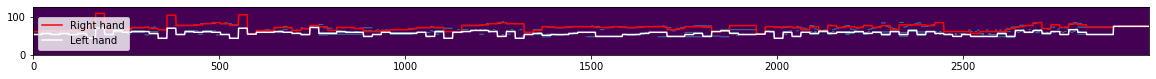

before post-processing 408 notes
Octave Transpose: #notes 408 transposed 5 notes , skipped 15
Merge discrete: merged  2  discrete notes
Drop discrete: dropped  0  discrete notes
Doubling Simplification: removed doubling 0
after post-processing, total notes: 406, removed 2 notes in total
0.05 24 480


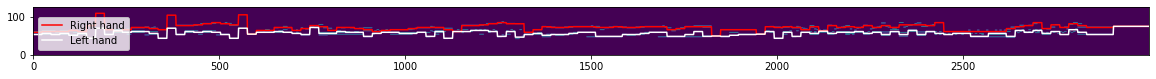

before post-processing 406 notes
Octave Transpose: #notes 406 transposed 0 notes , skipped 14
Merge discrete: merged  0  discrete notes
Drop discrete: dropped  0  discrete notes
Doubling Simplification: removed doubling 0
after post-processing, total notes: 406, removed 0 notes in total
0.05 24 480


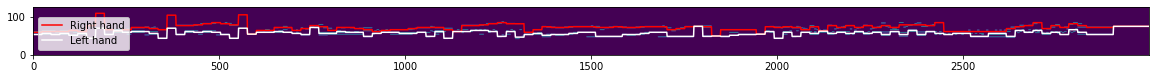

before post-processing 406 notes
Octave Transpose: #notes 406 transposed 0 notes , skipped 14
Merge discrete: merged  0  discrete notes
Drop discrete: dropped  0  discrete notes
Doubling Simplification: removed doubling 0
after post-processing, total notes: 406, removed 0 notes in total
0.05 24 480


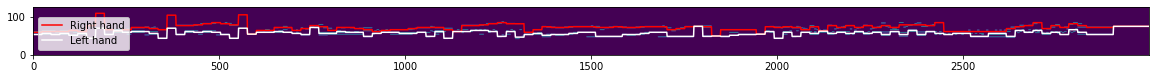

In [128]:
# main
merge_threshold=1# #minimum separation between notes in same pitch
discrete_note_threshold=1 #minimum length of a note

notes,tick_per_beat = read_midi("test_r2flarge.mid")
org_notes=len(notes)
print(f'before post-processing {org_notes} notes')
notes = trim_long_notes(notes, tick_per_beat)
notes,centers_per_beat,range_per_beat = octave_transpose(notes, tick_per_beat)
notes = merge_discrete_note(notes)
notes = drop_discrete_note(notes)
notes = doubling_simplification(notes,centers_per_beat, tick_per_beat)
cur_notes=len(notes)
print(f'after post-processing, total notes: {cur_notes}, removed {org_notes-cur_notes} notes in total')
visualize(notes,tick_per_beat,centers_per_beat=centers_per_beat,range_per_beat=None,length=3000)
write_midi(notes, "post_processed.mid", tick_per_beat)

minimum_runs=3
run=0
while True:
    notes,tick_per_beat = read_midi("post_processed.mid")
    org_notes=len(notes)
    print(f'before post-processing {org_notes} notes')
    notes = trim_long_notes(notes, tick_per_beat)
    notes,centers_per_beat,range_per_beat = octave_transpose(notes, tick_per_beat,5,2,range_per_beat)
    notes = merge_discrete_note(notes)
    notes = drop_discrete_note(notes)
    notes = doubling_simplification(notes,centers_per_beat, tick_per_beat)
    cur_notes=len(notes)
    print(f'after post-processing, total notes: {cur_notes}, removed {org_notes-cur_notes} notes in total')
    visualize(notes,tick_per_beat,centers_per_beat=centers_per_beat,range_per_beat=None,length=3000)
    write_midi(notes, "post_processed.mid", tick_per_beat)
    run+=1
    #termination
    if org_notes-cur_notes==0 and run>=minimum_runs:        
        break

In [ ]:
centers_per_beat[88]

# DEBUG

In [ ]:
    for beat in range(10):
        notes_within_window = get_notes_of_beat(notes,beat,tick_per_beat)
        pitches_within_window = np.array([note.pitch for note in notes_within_window])
        upper_limit,lower_limit = max(pitches_within_window),min(pitches_within_window)
        range_per_beat.append([lower_limit,upper_limit])

In [ ]:
octave_transpose(notes, tick_per_beat)

In [ ]:
centers_per_beat=[]
range_per_beat=[]

ahead=1
after=1

start=ahead
end=(notes[-1].start//tick_per_beat - after) +1

trace_start_idx=0

for beat in range(end):
    notes_within_window = notes[trace_start_idx:find_note_idx_before(notes, tick_per_beat, beat+1)+1]
    print(notes_within_window)
    pitches_within_window = np.array([note.pitch for note in notes_within_window])
    upper_limit,lower_limit = max(pitches_within_window),min(pitches_within_window)
    range_per_beat.append([lower_limit,upper_limit])
    trace_start_idx+=find_note_idx_before(notes, tick_per_beat, beat+1)+1
range_per_beat

In [ ]:
notes

In [ ]:
notes